In [1]:
# Applied Machine Learning (HOUSECS 59-03)
# Fall 2018, Duke University
# Evaluation of Machine Learning Models

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

Let's begin by revisiting the dataset that looks at housing prices in Boston: load the data into a Pandas dataframe, and plot it with respect to a single feature, LSTAT (% lower status of the population).

In [3]:
# load dataset
boston = datasets.load_boston()
print(boston["DESCR"])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df["MEDV"] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


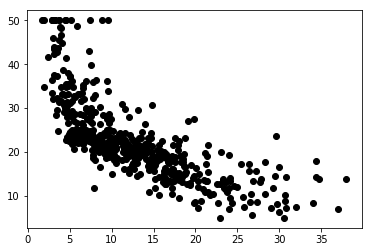

In [5]:
# plot LSTAT vs. MEDV
plt.scatter(df["LSTAT"], df["MEDV"], color="black")

---
We can create a second-degree regularized (via ridge regression) multivariate model, taking three of the features available (RM, DIS, and LSTAT) as input to predict the value of a home (MEDV). We can use the first 300 points as training, and test on the remaining 206, making sure to normalize first. Take a look at the mean absolute error, mean squared error (MSE), and $R^2$ value of the model, and a plot of how we did with respect to RM.

In [6]:
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=True)
poly_feat = poly.fit_transform(df[["RM", "DIS", "LSTAT"]])

In [7]:
# create and fit regularized model
regularized_regr = sklearn.linear_model.Ridge(normalize=True, alpha=0)
regularized_regr.fit(poly_feat[:300], df.loc[:299, "MEDV"])

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
   random_state=None, solver='auto', tol=0.001)

In [8]:
# predict model
regularized_pred = regularized_regr.predict(poly_feat[300:])
print("mean absolute error", sklearn.metrics.mean_absolute_error(regularized_pred, df.loc[300:, "MEDV"]))
print("mean squared error", sklearn.metrics.mean_squared_error(regularized_pred, df.loc[300:, "MEDV"]))
print("r^2 score", sklearn.metrics.r2_score(df.loc[300:, "MEDV"], regularized_pred)) # y_true, y_pred

mean absolute error 4.471556587178042
mean squared error 41.708742334633925
r^2 score 0.322279932371771


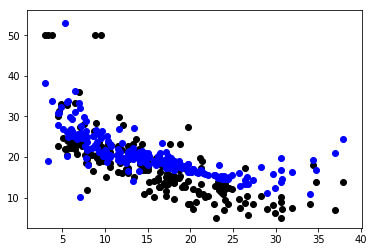

In [9]:
# plot predictions w.r.t. LSTAT
plt.scatter(df.loc[300:, ["LSTAT"]], df.loc[300:, "MEDV"], color="black") # true labels
plt.scatter(df.loc[300:, ["LSTAT"]], regularized_pred, color="blue") # predictions

With a neighbor, discuss the interpretation of the mean absolute error, mean squared error, and $R^2$ value of the model. How well did our model perform, and does the plot corroborate our results?

---
Perhaps we now want to determine the optimal coefficient $\alpha$ in a fourth-degree polynomial model. Let's use 10-fold cross-validation to determine such a value.

In [10]:
poly = sklearn.preprocessing.PolynomialFeatures(degree=4, include_bias=False)
poly_feat = poly.fit_transform(df[["RM", "DIS", "LSTAT"]])

In [11]:
alpha_grid = np.linspace(0, 10, 51) # hyperparameter grid
kf_test = sklearn.model_selection.KFold(n_splits=10)
kf_val = sklearn.model_selection.KFold(n_splits=9)

print("best alpha", "\t", "average validation MSE", "\t", "test MSE")
for train_val_index, test_index in kf_test.split(poly_feat): # outer (testing) loop
    X_train_val, y_train_val = poly_feat[train_val_index], np.array(df["MEDV"][train_val_index])
    X_test, y_test = poly_feat[test_index], np.array(df["MEDV"][test_index])
    
    alpha_mse_grid = np.array([0]*len(alpha_grid))
    for train_index, val_index in kf_val.split(X_train_val): # inner (validation) loop
        X_train, y_train = X_train_val[train_index], y_train_val[train_index]
        X_val, y_val = X_train_val[val_index], y_train_val[val_index]
        
        for n, alpha in enumerate(alpha_grid): # hyperparameter grid search (loop)
            val_regr = sklearn.linear_model.Ridge(normalize=True, alpha=alpha)
            val_regr.fit(X_train, y_train)
            val_mse = sklearn.metrics.mean_squared_error(val_regr.predict(X_val), y_val)
            alpha_mse_grid[n] += val_mse
    alpha_mse_grid = alpha_mse_grid/kf_val.n_splits # compute average
    best_alpha, best_avg_val_mse = alpha_grid[np.argmin(alpha_mse_grid)], np.min(alpha_mse_grid)

    test_regr = sklearn.linear_model.Ridge(normalize=True, alpha=best_alpha)
    test_regr.fit(X_train_val, y_train_val)
    test_mse = sklearn.metrics.mean_squared_error(test_regr.predict(X_test), y_test)
    print(best_alpha, "\t\t", round(best_avg_val_mse, 1), "\t\t\t\t", round(test_mse, 1))

best alpha 	 average validation MSE 	 test MSE
0.2 		 24.9 				 11.7
0.2 		 25.7 				 7.0
0.2 		 25.1 				 9.6
0.2 		 24.6 				 27.1
0.2 		 24.4 				 17.6
0.2 		 24.6 				 21.9
0.2 		 24.9 				 11.8
0.2 		 16.4 				 98.0
0.2 		 26.1 				 21.3
0.2 		 24.4 				 14.5


There seems to be consensus that the best value of $\alpha$ is 0.2. Let's see how our model performs, with $\alpha = 0.2$ and degree = $4$. For comparison, change the value of $\alpha$ a bit, and see how the MSE adjusts.

mean absolute error 4.919735838436536
mean squared error 46.464565629175716
r^2 score 0.24500316245755627


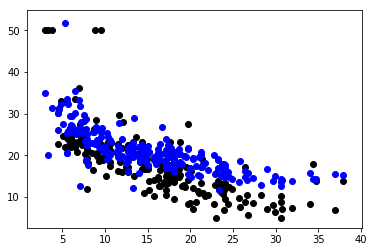

In [12]:
poly = sklearn.preprocessing.PolynomialFeatures(degree=4, include_bias=False)
poly_feat = poly.fit_transform(df[["RM", "DIS", "LSTAT"]])

# create and fit regularized model
regularized_regr = sklearn.linear_model.Ridge(normalize=True, alpha=0.2)
regularized_regr.fit(poly_feat[:300], df.loc[:299, "MEDV"])

# predict model
regularized_pred = regularized_regr.predict(poly_feat[300:])
print("mean absolute error", sklearn.metrics.mean_absolute_error(regularized_pred, df.loc[300:, "MEDV"]))
print("mean squared error", sklearn.metrics.mean_squared_error(regularized_pred, df.loc[300:, "MEDV"]))
print("r^2 score", sklearn.metrics.r2_score(df.loc[300:, "MEDV"], regularized_pred)) # y_true, y_pred

# plot predictions w.r.t. LSTAT
plt.scatter(df.loc[300:, ["LSTAT"]], df.loc[300:, "MEDV"], color="black") # true labels
plt.scatter(df.loc[300:, ["LSTAT"]], regularized_pred, color="blue") # predictions

Note that there are other hyperparameters that can be tuned, including the degree of the polynomial. A remaining exercise is to tune additional hyperparameters, including degree.

---
Let's explore a new dataset that looks at handwritten digits, and load the data into matrices.

In [13]:
digits = datasets.load_digits()
print(digits["DESCR"])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [14]:
X, y = digits.data, digits.target%2 == 0

Even though we haven't formally introduced a classification model in the course yet, we'll use a model called support vector machines. The input will be an 8x8 image of integer pixels (between 0 and 16), and the output will be whether the digit is even (binary classification). We'll compute various classification metrics over our model. We'll use the first 1200 instances for training, and the last 597 for testing.

In [15]:
X_train, y_train = X[:1200], y[:1200]
X_test, y_test = X[1200:], y[1200:]

In [16]:
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
y_pred = svm_model.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred))
print("misclassification error", 1-accuracy_score(y_test, y_pred))

accuracy 0.7202680067001676
misclassification error 0.27973199329983245


From the testing set, we can calculate the accuracy and misclassification error. We can also compute other important metrics, including precision, recall, and the F1-score.

In [18]:
print("precision score", precision_score(y_test, y_pred))
print("recall score", recall_score(y_test, y_pred))
print("F1-score", f1_score(y_test, y_pred))

precision score 1.0
recall score 0.4358108108108108
F1-score 0.6070588235294118


Also of importance are confusion matrices, which provide a concise presentation of the predictive power of a model, and ROC curves, both of which are easy to produce using scikit-learn.

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("confusion matrix")
print("TP", conf_matrix[0][0], "\t", "FP", conf_matrix[0][1])
print("FN", conf_matrix[1][0], "\t", "TN", conf_matrix[1][1])

confusion matrix
TP 301 	 FP 0
FN 167 	 TN 129


In [20]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')

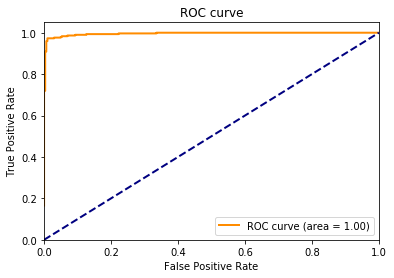

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

That's all! A remaining exercise is to perform k-fold cross-validation to tune a hyperparameter for support vector machines, if time remains. (One possible such hyperparameter is the kernel used.)